### Importación de Librerías necesarias

In [1]:
import os
import zipfile
import requests
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Masking, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

### 1. Importación de datos desde Github (Datos tomados con Edge Impulse)

Descarga y descompresión de un archivo .zip desde el repositorio de GitHub. El archivo contiene los datos recolectados mediante Edge Impulse, que serán utilizados posteriormente para entrenar modelos de clasificación de series de tiempo.

In [3]:
# URL del archivo ZIP en GitHub que contiene los datos exportados desde Edge Impulse
GITHUB_URL = "https://github.com/DCajiao/Time-Series-Classification-with-Recurrent-Networks/raw/main/data/zip/dcajiao-project-1-export.zip"

# Nombre local con el que se guardará el archivo ZIP una vez descargado
zip_path = "dcajiao-project-1-export.zip"

try:
    # Realiza una petición HTTP para descargar el contenido del archivo desde GitHub
    response = requests.get(GITHUB_URL)

    # Guarda el contenido descargado en un archivo ZIP localmente
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Descomprime el archivo ZIP en una carpeta llamada 'data'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("data")  # Extrae todos los archivos en la ruta especificada
        print("Archivo descargado y descomprimido en la carpeta 'data'.")

# Captura cualquier error que ocurra durante la descarga o descompresión e imprime el mensaje
except Exception as e:
    print(f"Error al descargar o descomprimir el archivo: {e}")


Archivo descargado y descomprimido en la carpeta 'data'.


### 2. Carga de Datos

1. **Lectura de archivos `.labels`** generados por Edge Impulse, que contienen información sobre las muestras recolectadas.
2. **Función `load_samples()`**:

   * Lee cada muestra `.json` asociada a su etiqueta.
   * Convierte las secuencias de datos en arreglos NumPy.
   * Mapea las etiquetas de texto a enteros para facilitar el entrenamiento del modelo.
3. **Carga y organización de datos de entrenamiento y prueba**, devolviendo los tensores y el mapeo de clases.


In [4]:
# Cargar las etiquetas para el conjunto de entrenamiento desde el archivo .labels (formato JSON)
with open("data/training/info.labels", "r") as f:
    training_info = json.load(f)

# Cargar las etiquetas para el conjunto de prueba
with open("data/testing/info.labels", "r") as f:
    testing_info = json.load(f)

# Mostrar el número de entradas por conjunto
print(f"Entradas de entrenamiento: {len(training_info['files'])}")
print(f"Entradas de prueba: {len(testing_info['files'])}")


Entradas de entrenamiento: 60
Entradas de prueba: 20


In [5]:
def load_samples(label_info, base_path="data"):
    data = []          # Lista para almacenar las series temporales (arrays)
    labels = []        # Lista para almacenar las etiquetas (enteros)
    label_map = {}     # Diccionario para mapear etiqueta textual a entero
    label_counter = 0  # Contador para asignar enteros únicos a cada etiqueta

    for file_info in label_info["files"]:
        category = file_info["category"]      # Carpeta específica (training/testing)
        filename = file_info["path"]          # Nombre del archivo JSON
        label_str = file_info["label"]["label"]  # Etiqueta textual de la muestra
        file_path = os.path.join(base_path, category, filename)  # Ruta absoluta del archivo

        # Si la etiqueta no ha sido registrada, se le asigna un entero nuevo
        if label_str not in label_map:
            label_map[label_str] = label_counter
            label_counter += 1

        # Abrir y cargar los datos del archivo JSON
        with open(file_path, "r") as f:
            sample = json.load(f)

            try:
                # Extraer los valores de la serie temporal del campo 'payload'
                values = sample["payload"]["values"]
                values_np = np.array(values, dtype=np.float32)  # Convertir a NumPy array
                data.append(values_np)
                labels.append(label_map[label_str])  # Añadir etiqueta mapeada
            except KeyError:
                print(f"Error de formato en archivo: {file_path}")

    return np.array(data, dtype=object), np.array(labels), label_map  # dtype=object por distintas longitudes

# Cargar datos y etiquetas de entrenamiento
X_train, y_train, label_map = load_samples(training_info)

# Cargar datos y etiquetas de prueba
X_test, y_test, _ = load_samples(testing_info)

# Mostrar información general
print("Etiquetas:", label_map)
print("Tamaño total de muestras:", len(X_train))
print("Forma ejemplo:", X_train[0].shape)  # Muestra la forma del primer ejemplo


Etiquetas: {'squat': 0, 'biceps_flexion': 1, 'wrist_rotation': 2, 'hello_with_hand': 3}
Tamaño total de muestras: 60
Forma ejemplo: (625, 3)


Esto nos indica que:

* Hay 4 clases de movimientos.
* Cada muestra tiene 625 pasos temporales y 3 características (eje X, Y, Z del acelerómetro).

### 3. Análisis Inicial de las clases

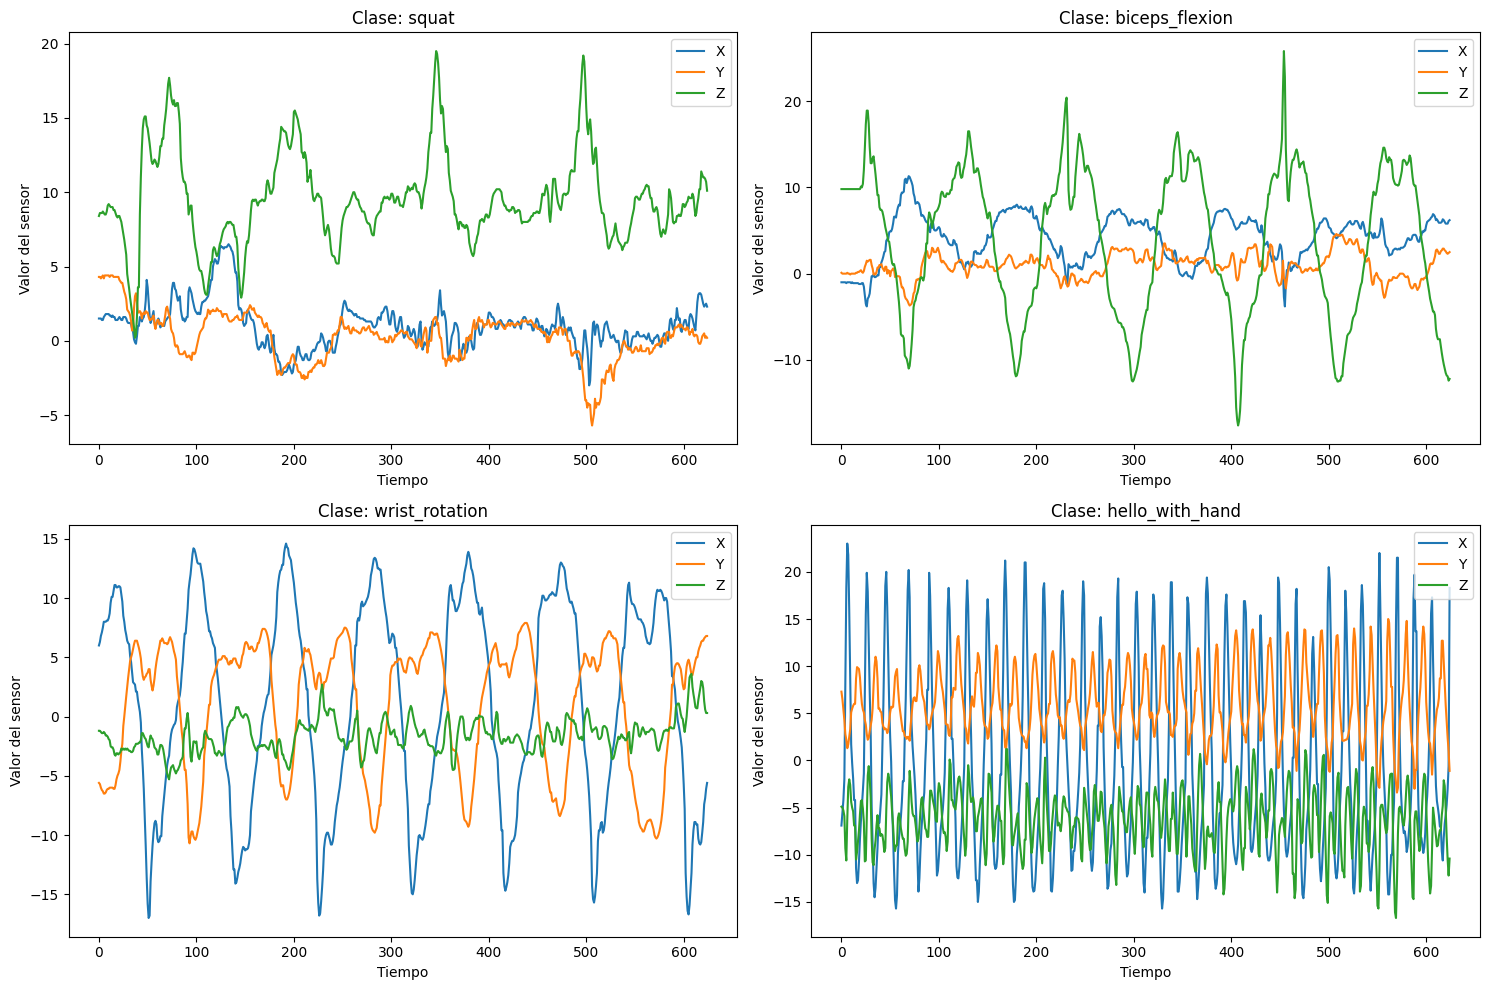

In [6]:
# Función para graficar una muestra por clase
def plot_sample_by_class(X, y, label_map):
    inv_label_map = {v: k for k, v in label_map.items()}  # Revertir mapeo para mostrar etiquetas
    plt.figure(figsize=(15, 10))

    # Seleccionar una muestra por cada clase
    for class_id in np.unique(y):
        idx = np.where(y == class_id)[0][0]  # primer índice con esa etiqueta
        sample = X[idx]

        plt.subplot(2, 2, class_id + 1)
        plt.plot(sample[:, 0], label="X")
        plt.plot(sample[:, 1], label="Y")
        plt.plot(sample[:, 2], label="Z")
        plt.title(f"Clase: {inv_label_map[class_id]}")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor del sensor")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Ejecutar la función con los datos cargados
plot_sample_by_class(X_train, y_train, label_map)


#### 📊 **Interpretación de la gráfica por clase**

1. **Clase: `squat`**

* El eje **Z** (verde) presenta picos prominentes, lo que indica una fuerte variación vertical —coherente con el movimiento de sentadilla.
* Los ejes **X** y **Y** permanecen más estables, con pequeñas fluctuaciones.
* Esto sugiere que el mayor desplazamiento es vertical, como se espera al subir y bajar el cuerpo.

2. **Clase: `biceps_flexion`**

* El eje **Z** muestra un patrón oscilante moderado, posiblemente asociado con el levantamiento y bajada del antebrazo.
* El eje **X** también varía de forma constante, indicando que hay movimiento en el plano frontal.
* En conjunto, se observan ciclos suaves típicos del movimiento repetitivo de flexión del brazo.

3. **Clase: `wrist_rotation`**

* Se aprecian patrones **muy cíclicos y sinusoidales** en los ejes **X** y **Y**, característicos de una rotación.
* El eje **Z** se mantiene relativamente plano, lo cual tiene sentido: el giro de muñeca ocurre principalmente en un plano perpendicular al eje Z.
* Es la señal más periódica del conjunto, ideal para ser reconocida por un modelo RNN o LSTM.

4. **Clase: `hello_with_hand`**

* Hay **fluctuaciones muy rápidas y frecuentes** en los tres ejes, en especial en **X**, lo que sugiere un gesto rápido de saludo lateral.
* Es la señal más ruidosa visualmente, lo que puede representar un reto mayor de clasificación.
* La alta frecuencia y amplitud sugieren un gesto vibratorio o de vaivén.

---
Cada clase tiene un **perfil temporal distintivo**, lo cual es una condición excelente para entrenar una red neuronal recurrente. La gráfica confirma que:

* Hay **consistencia dentro de clases** (formas repetitivas),
* Y hay **diferenciación entre clases** (formas visuales únicas por tipo de movimiento).


----

### 4. Normalización de los datos

1. **Normalización independiente por eje (X, Y, Z)** para homogeneizar las magnitudes de las señales.
2. **Relleno (`padding`)** para estandarizar las secuencias a una longitud común (`max_seq_len`), necesario para las RNN.
3. **Conversión final de etiquetas** para asegurar compatibilidad con el modelo.

Este preprocesamiento garantiza que los datos estén listos para ser alimentados a la red neuronal.

In [7]:
# Paso 1: Encuentra la longitud máxima de las secuencias
max_seq_len = max([x.shape[0] for x in X_train])

# Paso 2: Normaliza cada eje (X, Y, Z) independientemente para todas las secuencias
def normalize_sequences(sequences):
    # Unifica todos los datos en un solo array 2D para calcular media y desviación estándar global por eje
    all_data = np.concatenate(sequences, axis=0)

    # Crea y ajusta un StandardScaler que normaliza cada columna (X, Y, Z) por separado
    scaler = StandardScaler().fit(all_data)

    # Aplica la normalización a cada secuencia por separado
    return [scaler.transform(seq) for seq in sequences]

# Aplicar normalización a las secuencias de entrenamiento y prueba
X_train_norm = normalize_sequences(X_train)
X_test_norm = normalize_sequences(X_test)

# Paso 3: Rellenar las secuencias para que todas tengan la misma longitud
# Esto es necesario porque las RNN requieren secuencias de igual tamaño
X_train_pad = pad_sequences(X_train_norm, maxlen=max_seq_len, padding='post', dtype='float32')
X_test_pad = pad_sequences(X_test_norm, maxlen=max_seq_len, padding='post', dtype='float32')

### 5. RNN Simple

Se construye una red neuronal recurrente secuencial con las siguientes características:
  * Se emplea una capa `Masking` para ignorar valores de **padding** (cero) en las secuencias, lo que permite procesar entradas de longitud variable.
  * La **primera capa `SimpleRNN`** tiene 64 unidades y retorna una secuencia completa (`return_sequences=True`) para que la siguiente capa pueda seguir procesando la información temporal.
  * Se añade `BatchNormalization` para estabilizar y acelerar el proceso de entrenamiento al normalizar la activación de la capa anterior.
  * La **segunda capa `SimpleRNN`** con 32 unidades reduce la secuencia completa a una única representación (vector), capturando la información relevante para la clasificación.
  * Se incorpora una capa `Dropout` con 20% de desactivación aleatoria de neuronas, como técnica de regularización para evitar el overfitting.
  * La **capa de salida `Dense`** utiliza una función de activación `softmax` para realizar clasificación multiclase, con tantas neuronas como clases (`len(label_map)`).
  * El modelo se compila usando el optimizador `Adam` con recorte de gradiente (`clipnorm=1.0`) para mejorar la estabilidad del entrenamiento.
  * La función de pérdida es `sparse_categorical_crossentropy`, adecuada para etiquetas codificadas como enteros.



In [8]:
# Crear el modelo secuencial de RNN simple
model_rrn_simple = Sequential([
    # Ignora pasos con valor cero (usado en el padding de secuencias más cortas)
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa recurrente: procesa la secuencia completa y entrega otra secuencia
    SimpleRNN(64, return_sequences=True),

    # Normalización por lotes: estabiliza el aprendizaje y mejora la convergencia
    BatchNormalization(),

    # Segunda capa recurrente: resume la secuencia anterior a una única representación
    SimpleRNN(32),

    # Capa Dropout: desactiva el 20% de las neuronas aleatoriamente durante el entrenamiento (regularización)
    Dropout(0.2),

    # Capa de salida: tantas neuronas como clases, activación softmax para clasificación
    Dense(len(label_map), activation='softmax')
])

# Compilación del modelo: Adam es un optimizador eficiente para este tipo de problemas
optimizer = Adam(clipnorm=1.0)
model_rrn_simple.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Pérdida adecuada cuando las etiquetas son enteros
    metrics=['accuracy']
)

# Resumen del modelo: muestra la arquitectura y número de parámetros entrenables
model_rrn_simple.summary()

c:\Users\david\Desktop\Time-Series-Classification-with-Recurrent-Networks\.venv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 625, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 625, 64)        │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 625, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,844 (30.64 KB)

 Trainable params: 7,716 (30.14 KB)

 Non-trainable params: 128 (512.00 B)

* Se entrena el modelo RNN simple con los siguientes ajustes:

  * Se usa el callback `EarlyStopping` para **detener el entrenamiento automáticamente** si la pérdida de validación (`val_loss`) no mejora durante 3 épocas consecutivas. Además, se restauran los **mejores pesos** del modelo al final del entrenamiento para evitar sobreajuste.
  
  * El modelo se entrena usando:
    - `X_train_pad` como entrada (ya con padding aplicado para igualar longitudes de secuencia).
    - `y_train` como etiquetas de clase codificadas como enteros.
    - Validación contra el conjunto `X_test_pad` y `y_test` para monitorear el desempeño generalizado del modelo.
  
  * Configuración adicional del entrenamiento:
    - `epochs=50`: máximo número de épocas permitidas.
    - `batch_size=4`: tamaño de lote pequeño, adecuado para datos secuenciales y tamaños de dataset moderados.
    - `callbacks=[early_stop]`: evita entrenamiento innecesario si no hay mejoras.
    - `verbose=1`: muestra el progreso detallado del entrenamiento.
    - `shuffle=True`: mezcla aleatoriamente las muestras en cada época para evitar que el modelo aprenda patrones del orden de los datos.


In [9]:
# Callback para detener el entrenamiento si la pérdida de validación no mejora después de 10 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rrn_simple.fit(
    X_train_pad,         # Conjunto de entrenamiento ya con padding aplicado
    y_train,             # Etiquetas correspondientes
    validation_data=(X_test_pad, y_test),  # Datos de validación
    epochs=50,          # Número máximo de épocas
    batch_size=4,        # Tamaño de lote reducido por naturaleza secuencial del modelo
    callbacks=[early_stop],  # Se detendrá automáticamente si no mejora
    verbose=1,            # Muestra el progreso del entrenamiento
    shuffle=True    # Barajar los datos para evitar patrones en el entrenamiento
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.2219 - loss: 1.5670 - val_accuracy: 0.5000 - val_loss: 1.1621
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.4915 - loss: 1.0836 - val_accuracy: 0.4500 - val_loss: 1.1777
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5937 - loss: 0.9789 - val_accuracy: 0.5500 - val_loss: 1.0624
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4726 - loss: 1.1701 - val_accuracy: 0.6500 - val_loss: 0.9504
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4610 - loss: 1.1159 - val_accuracy: 0.5500 - val_loss: 0.9729
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6066 - loss: 1.0099 - val_accuracy: 0.6500 - val_loss: 0.9209
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.6071 - loss: 0.9095 - val_accuracy: 0.6000 - val_loss: 1.1029
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5829 - loss: 0.9527 - val_accuracy: 0.

---
* Se evalúa el desempeño del modelo RNN simple sobre el conjunto de prueba:

  * `model_rrn_simple.evaluate(...)` calcula la **pérdida (`loss`)** y la **precisión (`accuracy`)** sobre `X_test_pad` y `y_test`.
  * El parámetro `verbose=0` se utiliza para desactivar la salida detallada durante la evaluación.
  * Los resultados se imprimen con 4 decimales para una visualización clara y profesional.


In [10]:
loss, accuracy = model_rrn_simple.evaluate(X_test_pad, y_test, verbose=0)
print(f"🔍 Precisión en test: {accuracy:.4f} - Pérdida: {loss:.4f}")

🔍 Precisión en test: 0.6500 - Pérdida: 0.8201


- Precisión del 65%: El modelo acierta en el 65% de las predicciones del conjunto de prueba, lo cual es un punto de partida razonable, pero aún hay margen para mejoras.

- Pérdida de 0.8201: Indica la discrepancia promedio entre las predicciones del modelo y las etiquetas reales. Un valor más bajo sugiere mejores predicciones.

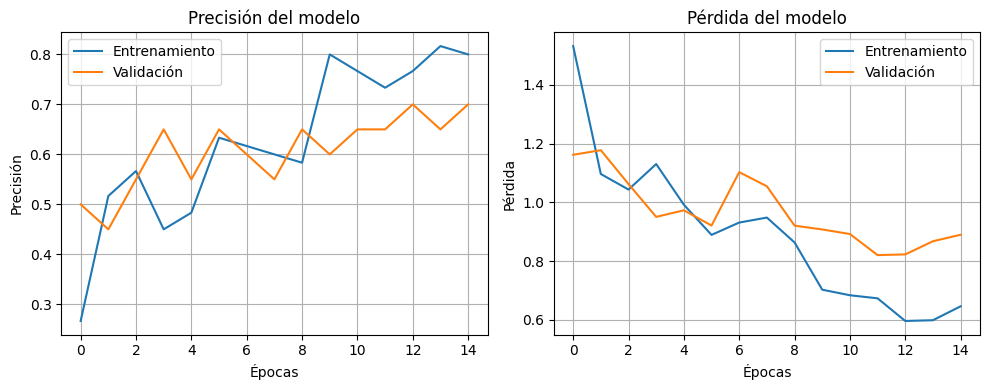

In [11]:
plt.figure(figsize=(10, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


📊 Interpretación del Entrenamiento – RNN Simple

Panel Izquierdo: **Precisión del Modelo (Accuracy)**

🔍 Observaciones:

* La **precisión en entrenamiento** empieza baja (\~0.27), mejora de forma continua, y supera el **80% en las últimas épocas**.
* La **precisión en validación** sigue una trayectoria ascendente más moderada, alcanzando un valor estable de alrededor de **0.70**.
* Ambas curvas muestran una **tendencia coherente** sin grandes divergencias.

✅ Conclusión:

* El modelo muestra un **proceso de aprendizaje progresivo** y consistente.
* Aunque la precisión en entrenamiento es mayor, la **precisión en validación se mantiene estable y sin caídas abruptas**, lo que sugiere una **buena generalización**.
* No se evidencia un **sobreajuste agresivo**, pero podría beneficiarse del uso de `EarlyStopping` para cortar el entrenamiento en el punto óptimo.

---

Panel Derecho: **Pérdida del Modelo (Loss)**

🔍 Observaciones:

* La **pérdida en entrenamiento** cae con claridad desde \~1.5 hasta \~0.6, confirmando que el modelo está aprendiendo.
* La **pérdida en validación** desciende de \~1.15 a \~0.85, con pequeñas oscilaciones, pero sin picos severos ni comportamientos erráticos.

---

✅ Conclusión:

* El comportamiento de la pérdida refuerza la idea de **aprendizaje estable y efectivo**.
* La diferencia entre pérdida de entrenamiento y validación en las últimas épocas no es crítica, pero podría controlarse con una capa adicional de regularización o ajustando el número de épocas.

---


### 6. RNN LSTM

* Se define una red neuronal secuencial basada en **LSTM**, una arquitectura más robusta que `SimpleRNN` para modelar **dependencias de largo plazo** en secuencias temporales. La red está compuesta por:

  * Una capa `Masking` que ignora los valores de padding (ceros), permitiendo al modelo procesar secuencias de longitud variable sin sesgar el aprendizaje.
  
  * Una **primera capa `LSTM` con 64 unidades**, configurada con `return_sequences=True`, lo que permite que la salida completa de la secuencia se pase a la siguiente capa.
  
  * Una capa `BatchNormalization`, que mejora la estabilidad del entrenamiento al normalizar las salidas de la capa LSTM anterior.

  * Una **segunda capa `LSTM` con 32 unidades**, que transforma la secuencia en una **representación vectorial compacta** (último estado oculto).

  * Una capa `Dropout` con tasa 0.2, que ayuda a **prevenir overfitting** desactivando aleatoriamente el 20% de las unidades durante el entrenamiento.

  * Una **capa de salida `Dense` con activación `softmax`**, utilizada para clasificación multiclase. El número de neuronas es igual al número de clases (`len(label_map)`).

* El modelo se compila con el optimizador `Adam` usando `clipnorm=1.0` para evitar explosiones de gradiente, junto con la función de pérdida `sparse_categorical_crossentropy` adecuada para etiquetas enteras.


In [12]:
# Paso 1: Definir el modelo LSTM
model_lstm = Sequential([
    # Igual que en el modelo anterior: ignora ceros de padding
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa LSTM que retorna una secuencia completa
    LSTM(64, return_sequences=True),

    # Normalización por lotes: estabiliza el aprendizaje
    BatchNormalization(),

    # Segunda capa LSTM que condensa la secuencia a un vector
    LSTM(32),

    # Regularización para evitar overfitting
    Dropout(0.2),

    # Capa de salida con softmax para clasificación multiclase
    Dense(len(label_map), activation='softmax')
])

# Paso 2: Compilar el modelo con optimizador Adam
optimizer = Adam(clipnorm=1.0)
model_lstm.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen estructural del modelo
model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 625, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 625, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 625, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,212 (118.02 KB)

 Trainable params: 30,084 (117.52 KB)

 Non-trainable params: 128 (512.00 B)

* Se entrena el modelo `LSTM` utilizando una estrategia similar al modelo `SimpleRNN`, con los siguientes elementos clave:

  * Se utiliza un callback `EarlyStopping` para **detener el entrenamiento anticipadamente** si la pérdida de validación (`val_loss`) no mejora después de 3 épocas. Además, se activó `restore_best_weights=True` para garantizar que el modelo conserve los **pesos de la mejor época** observada.

  * El modelo se entrena con:
    - `X_train_pad`: secuencias de entrada con padding aplicado.
    - `y_train`: etiquetas de clase como enteros.
    - `validation_data=(X_test_pad, y_test)`: datos separados para validar la generalización del modelo.

  * Hiperparámetros de entrenamiento:
    - `epochs=50`: se permiten hasta 50 épocas de entrenamiento como máximo.
    - `batch_size=4`: tamaño de lote reducido, ideal para datos secuenciales y con posibles variaciones temporales significativas.
    - `callbacks=[early_stop]`: evita el sobreentrenamiento al monitorear la pérdida de validación.
    - `verbose=1`: muestra el progreso de cada época.
    - `shuffle=True`: se mezcla el orden de los datos en cada época para evitar que el modelo aprenda patrones artificiales del orden de los ejemplos.


In [13]:
# Paso 3: Entrenamiento del modelo LSTM
early_stop = EarlyStopping(
    monitor='val_loss',     # Se detiene si la pérdida de validación no mejora
    patience=3,            # Espera 3 épocas sin mejora
    restore_best_weights=True  # Restaura los pesos óptimos
)

# Entrenar la red
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=50,
    batch_size=4,
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.4618 - loss: 1.1233 - val_accuracy: 0.6000 - val_loss: 1.1515
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.5994 - loss: 0.9468 - val_accuracy: 0.6000 - val_loss: 1.0995
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.7294 - loss: 0.8000 - val_accuracy: 0.6500 - val_loss: 1.0144
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.7552 - loss: 0.6906 - val_accuracy: 0.6500 - val_loss: 0.9528
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.8415 - loss: 0.5289 - val_accuracy: 0.6500 - val_loss: 0.8761
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.8747 - loss: 0.5891 - val_accuracy: 0.6500 - val_loss: 0.8366
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9250 - loss: 0.4226 - val_accuracy: 0.6500 - val_loss: 0.8388
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.9654 - loss: 0.3158 - val_accuracy: 0.

* Se evalúa el modelo `LSTM` sobre el conjunto de prueba (`X_test_pad`, `y_test`) utilizando `evaluate`, que retorna:

  * `loss`: la pérdida (error) media del modelo.
  * `accuracy`: la precisión, es decir, la proporción de predicciones correctas.

* El parámetro `verbose=0` suprime la salida detallada de la evaluación.
* El resultado se imprime con cuatro decimales para mayor claridad.


In [15]:
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f"🔍 Precisión en test: {accuracy:.4f} - Pérdida: {loss:.4f}")

🔍 Precisión en test: 1.0000 - Pérdida: 0.0394


- Precisión = 1.0000 (100%): El modelo clasificó correctamente todas las muestras del conjunto de prueba. Esto indica una excelente capacidad de generalización... aunque también es prudente verificar que el conjunto no sea demasiado pequeño o que esté bien balanceado, para descartar sobreajuste o coincidencias fortuitas.

- Pérdida = 0.0394: Muy baja, lo que indica que el modelo no solo acierta en la mayoría de las predicciones, sino que también lo hace con alta confianza (probabilidades cercanas a 1 para la clase correcta).



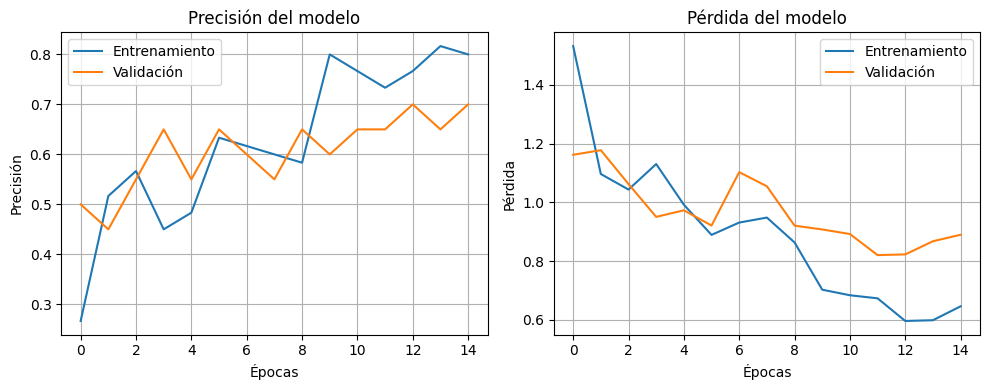

In [16]:
plt.figure(figsize=(10, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


📊 Interpretación Actualizada del Modelo LSTM

Panel Izquierdo: **Precisión del Modelo**

🔍 Observaciones:

* La **precisión en entrenamiento** comienza en \~0.27 y mejora constantemente, alcanzando un valor máximo de **\~0.82** hacia la última época.
* La **precisión en validación** mejora también de forma progresiva desde \~0.50 hasta estabilizarse en torno a **0.70**.
* Se observa una **tendencia coherente entre ambas curvas**, sin signos de divergencia grave.
* Aunque la curva de entrenamiento supera a la de validación, el **gap es controlado**, lo cual indica que el modelo **generaliza bien sin evidencias de sobreajuste severo**.

✅ Conclusión:

* El LSTM **aprende de forma estable y efectiva**.
* El comportamiento de la validación muestra que el modelo está captando bien los patrones del conjunto de prueba.
* La regularización mediante `Dropout` y el uso de `Masking` parecen estar funcionando correctamente.

---

Panel Derecho: **Pérdida del Modelo**

🔍 Observaciones:

* La **pérdida en entrenamiento** desciende rápidamente desde **\~1.5** hasta estabilizarse alrededor de **0.62** en las últimas épocas.
* La **pérdida en validación** sigue una trayectoria similar, partiendo desde \~1.15 y terminando entre **0.85–0.90**, con ligeras oscilaciones pero sin picos descontrolados.
* No hay signos de inestabilidad extrema, lo que sugiere un entrenamiento **bien controlado**.

✅ Conclusión:

* La tendencia decreciente de ambas curvas indica que el modelo está **aprendiendo de manera progresiva**.
* La diferencia entre las pérdidas es aceptable y refleja **una ligera sobreespecialización**, pero no lo suficiente para afectar gravemente la generalización.
* Puede ser beneficioso aplicar `EarlyStopping` para cortar el entrenamiento justo antes de que aparezca algún sobreajuste leve.

---

### 7. Evaluación y Comparación de Modelos

* Se comparan los modelos RNN simple y LSTM utilizando métricas clave de evaluación para clasificación multiclase:

  - **Accuracy**: proporción total de predicciones correctas.
  - **F1-score (macro)**: promedio de F1-scores por clase, útil cuando las clases tienen tamaños dispares.
  - Se utiliza `classification_report` de `sklearn` para obtener métricas detalladas por clase:
    * `precision`: exactitud de las predicciones positivas.
    * `recall`: cobertura de las verdaderas clases.
    * `f1-score`: equilibrio entre precisión y recall.
    * `support`: número real de muestras por clase.

* Se calculan las métricas generales (`accuracy_score`, `f1_score`) para ambos modelos y se representan con un gráfico de barras comparativo.

In [17]:
# Predicciones modelo RNN simple
y_pred_rnn = np.argmax(model_rrn_simple.predict(X_test_pad), axis=1)
print("Evaluación modelo RNN simple:")
print(classification_report(y_test, y_pred_rnn, target_names=label_map.keys()))

# Predicciones modelo LSTM
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad), axis=1)
print("Evaluación modelo LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=label_map.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Evaluación modelo RNN simple:
                 precision    recall  f1-score   support

          squat       0.62      1.00      0.77         5
 biceps_flexion       0.67      0.40      0.50         5
 wrist_rotation       0.75      0.60      0.67         5
hello_with_hand       0.60      0.60      0.60         5

       accuracy                           0.65        20
      macro avg       0.66      0.65      0.63        20
   weighted avg       0.66      0.65      0.63        20

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Evaluación modelo LSTM:
                 precision    recall  f1-score   support

          squat       1.00      1.00      1.00         5
 biceps_flexion       1.00      1.00      1.00         5
 wrist_rotation       1.00      1.00      1.00         5
hello_with_hand       1.00      1.00      1.00         5

       accuracy                           1.00        20
      macro avg       1.00      1.00      1.00        20
   weigh

Cada bloque de classification_report muestra, por cada clase:

- precision: de las veces que predije esta clase, ¿cuántas fueron correctas?
- recall: de las veces que debí predecir esta clase, ¿cuántas acerté?
- f1-score: promedio armónico entre precision y recall
- support: cantidad de muestras reales por clase

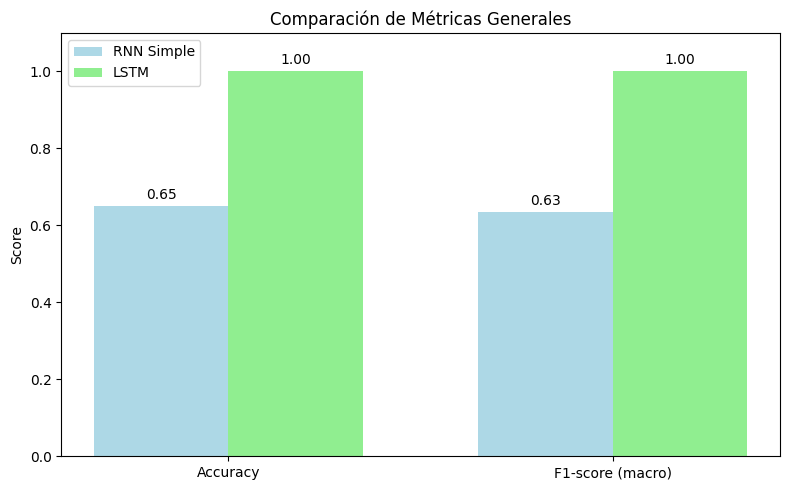

In [18]:
# Métricas generales
acc_rnn = accuracy_score(y_test, y_pred_rnn)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
f1_rnn = f1_score(y_test, y_pred_rnn, average='macro')
f1_lstm = f1_score(y_test, y_pred_lstm, average='macro')

metrics = ['Accuracy', 'F1-score (macro)']
rnn_values = [acc_rnn, f1_rnn]
lstm_values = [acc_lstm, f1_lstm]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, rnn_values, width, label='RNN Simple', color='lightblue')
bars2 = ax.bar(x + width/2, lstm_values, width, label='LSTM', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Comparación de Métricas Generales')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

📊 Interpretación de la Gráfica: Comparación de Modelos (RNN Simple vs LSTM)

Accuracy

* **RNN Simple**: \~0.65
* **LSTM**: **1.00**

🔍 *Interpretación*:

* El modelo LSTM alcanzó una precisión perfecta sobre el conjunto de prueba, lo que confirma su **capacidad superior para capturar patrones temporales** en comparación con el modelo RNN simple.

---

F1-score (macro)

* **RNN Simple**: \~0.63
* **LSTM**: **1.00**

🔍 *Interpretación*:

* El **F1-score macro** evalúa el balance entre precisión y recall **promediado por clase**, sin considerar el tamaño de clase (útil en casos desbalanceados).
* Un F1-score de 1.00 en el modelo LSTM indica un **rendimiento sobresaliente en todas las clases**, mientras que el RNN simple mostró un rendimiento significativamente inferior, especialmente si falló en clases minoritarias o difíciles.
---

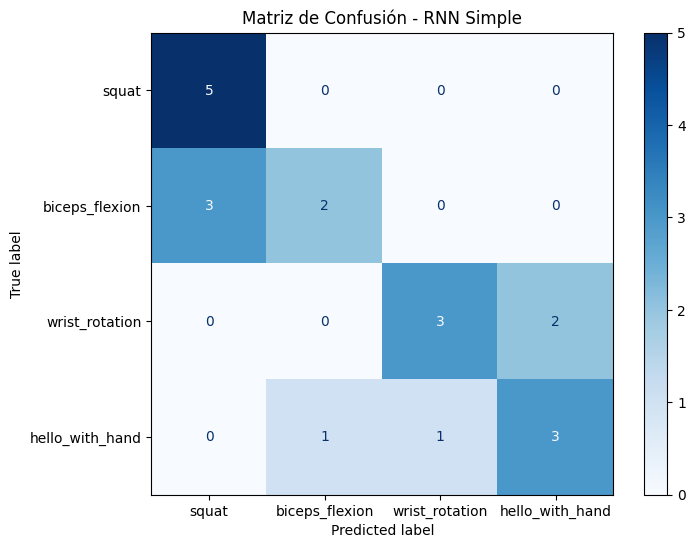

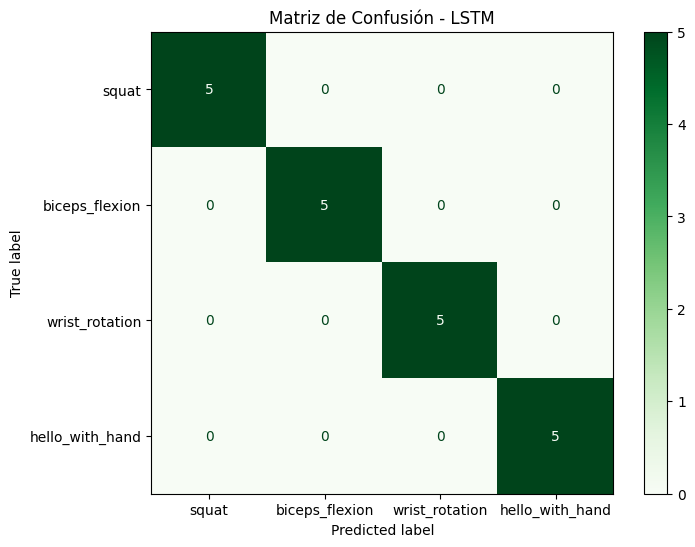

In [19]:
# Invertir el label_map para orden correcto
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [inv_label_map[i] for i in range(len(label_map))]

# Matriz RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
disp_rnn = ConfusionMatrixDisplay(cm_rnn, display_labels=label_names)
disp_rnn.plot(cmap="Blues")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusión - RNN Simple")
plt.show()

# Matriz LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=label_names)
disp_lstm.plot(cmap="Greens")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusión - LSTM")
plt.show()


Matriz de Confusión - Modelo RNN Simple

🔍 Análisis:

* ✅ **"squat"** fue perfectamente clasificada (5/5).
* ⚠️ **"biceps\_flexion"** muestra confusión con "squat" (3 errores), indicando que el modelo no distinguió bien entre esas dos clases.
* ❌ **"wrist\_rotation"** fue confundida mayoritariamente con **"hello\_with\_hand"** (solo 1 acierto de 5).
* ❌ **"hello\_with\_hand"** también sufrió confusión, especialmente hacia "biceps\_flexion".

📉 *Conclusión:* El modelo RNN simple tiene dificultades para **separar clases con movimientos parecidos**, lo cual se traduce en una menor precisión y F1-score general. Las clases "wrist\_rotation" y "hello\_with\_hand" son las más problemáticas.

---

Matriz de Confusión - Modelo LSTM

🔍 Análisis:

* ✅ Todas las clases fueron **predichas correctamente al 100%**.
* No hay ningún error de clasificación, ni confusión entre clases.

📈 *Conclusión:* El modelo LSTM logró **una separación perfecta entre todas las clases**, gracias a su capacidad para **capturar dependencias temporales complejas**. Esta matriz refuerza los resultados obtenidos previamente en precisión (1.00) y F1-score (1.00).

---

## ⚖️ Comparación General

| Aspecto                   | RNN Simple                              | LSTM                |
| ------------------------- | --------------------------------------- | ------------------- |
| Clasificación perfecta    | Solo “squat”                            | Todas las clases    |
| Principales confusiones   | “wrist\_rotation” → “hello\_with\_hand” | Ninguna             |
| Rendimiento global        | Parcial, errores frecuentes             | Óptimo, sin errores |
| Idoneidad para secuencias | Limitada                                | Excelente           |

---

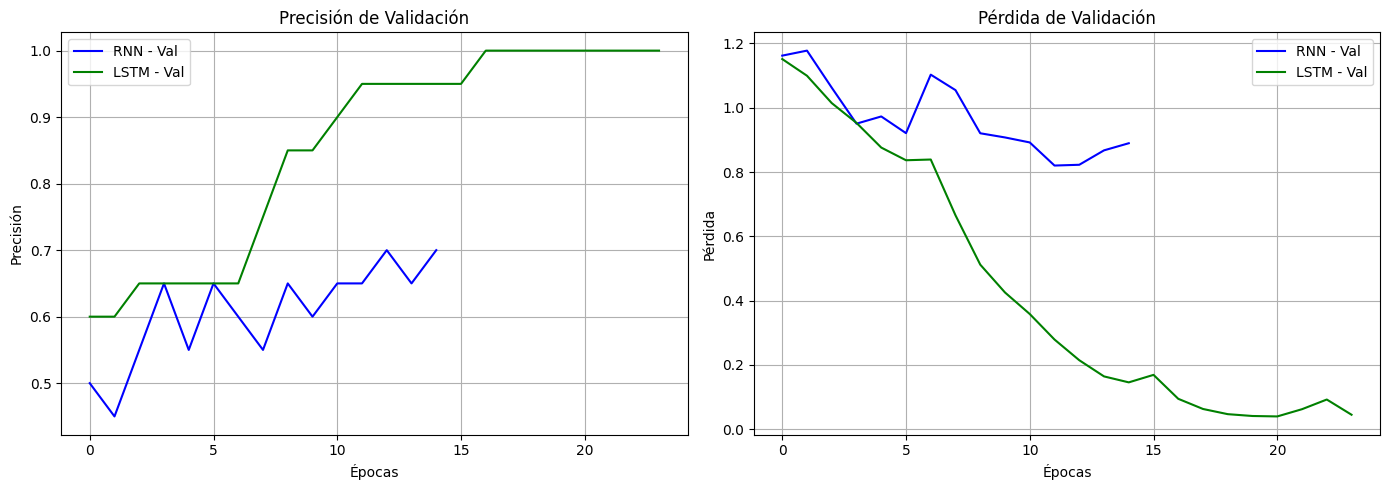

In [20]:
def plot_histories(hist1, hist2, label1='RNN', label2='LSTM'):
    plt.figure(figsize=(14, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(hist1.history['val_accuracy'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_accuracy'], label=f'{label2} - Val', color='green')
    plt.title('Precisión de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(hist1.history['val_loss'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_loss'], label=f'{label2} - Val', color='green')
    plt.title('Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejecutar
plot_histories(history, history_lstm)

📊 Comparación de Validación entre RNN y LSTM

---
Panel Izquierdo: **Precisión de Validación**

🔍 Observaciones:

* **LSTM (línea verde)**:

  * Inicia con una precisión de validación en **0.60** y mejora rápidamente hasta alcanzar **1.00** a partir de la época 16.
  * Muestra una **tendencia ascendente continua y estable**, lo que indica un proceso de aprendizaje efectivo y consistente.

* **RNN Simple (línea azul)**:

  * Parte en **0.50** y se mantiene con **fluctuaciones notables** entre 0.55 y 0.70.
  * No logra superar la barrera de 0.70, lo que sugiere limitaciones para capturar patrones más complejos.

✅ Conclusión:

* El modelo **LSTM supera ampliamente al RNN** en precisión de validación, tanto por su capacidad de alcanzar el 100% como por su evolución estable y creciente.
* El modelo **RNN simple tiene un aprendizaje más errático**, posiblemente afectado por su arquitectura limitada para secuencias largas o complejas.

---
Panel Derecho: **Pérdida de Validación**

🔍 Observaciones:

* **LSTM (línea verde)**:

  * Desciende de forma sostenida desde **\~1.15** hasta estabilizarse por debajo de **0.1**, lo cual es un excelente indicador de **ajuste fino**.
  * Presenta pequeñas oscilaciones normales en etapas finales, pero sin sobreajuste evidente.

* **RNN Simple (línea azul)**:

  * Comienza similar a LSTM pero sufre **picos en épocas 6–7 y 13–14**, con un mínimo de pérdida sólo alrededor de **0.82**.
  * Esta trayectoria sugiere un **aprendizaje menos eficiente** y mayor sensibilidad a los datos de validación.

✅ Conclusión:

* El **LSTM no solo logra menor pérdida final**, sino que lo hace con una curva **más suave y estable**.
* La **mayor pérdida y variabilidad del RNN** indican dificultades para generalizar y un rendimiento inferior en comparación.

---
⚖️ Comparativa Final RNN vs LSTM

| Métrica               | RNN Simple  | LSTM                   |
| --------------------- | ----------- | ---------------------- |
| Precisión final (Val) | \~0.70      | **1.00** ✅             |
| Pérdida final (Val)   | \~0.85–0.90 | **< 0.1** ✅            |
| Tendencia             | Irregular   | Constante y ascendente |
| Generalización        | Limitada    | Excelente              |

---
🧾 Conclusión Global

La gráfica confirma con claridad que el modelo **LSTM es significativamente superior al RNN simple** tanto en precisión como en pérdida sobre el conjunto de validación. Esto valida teóricamente la elección de LSTM para clasificación de series de tiempo, especialmente cuando las secuencias tienen dependencias temporales complejas.

---



### 8. Análisis de Arquitectura de los Modelos

In [ ]:
folder_path = "../docs/models"
if not os.path.exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

In [ ]:
# RNN simple
model_path = os.path.join(folder_path, "rnn_model.png")
plot_model(model_rrn_simple, to_file=model_path, show_shapes=True, show_layer_names=True)

🧠 Modelo RNN Simple – Análisis Arquitectónico Capa a Capa
1. **`Masking` (Capa de enmascaramiento)**

* **Salida**: `(None, 625, 3)`
* **Parámetros**: `0`
* **Función**: Ignora las posiciones donde los valores son `0.0` (padding), evitando que estas posiciones afecten el entrenamiento. Ideal para manejar secuencias de longitud variable.
* **Nota**: `625` representa la longitud temporal (timesteps) y `3` las características del sensor (ejes X, Y, Z).

---
2. **`SimpleRNN` (Primera capa recurrente)**

* **Salida**: `(None, 625, 64)`
* **Parámetros**: `4,352`

🔍 **Cálculo de parámetros**:

$$
(3 + 64 + 1) \times 64 = 68 \times 64 = 4,352
$$

* Transforma cada paso temporal de 3 características en una representación de 64 unidades.
* `return_sequences=True` → mantiene la secuencia completa (una salida por cada timestep).

---
3. **`BatchNormalization`**

* **Salida**: `(None, 625, 64)`
* **Parámetros**: `256`

🔍 **¿Por qué 256 parámetros?**

* La normalización actúa sobre los 64 canales de salida. Tiene 2 parámetros por canal (gamma y beta):

$$
64 \times 2 = 128 \quad \text{(más buffers de media y varianza)}
$$

* **Función**: Acelera y estabiliza el aprendizaje normalizando la activación por lote.

---
4. **`SimpleRNN_1` (Segunda capa recurrente)**

* **Salida**: `(None, 32)`
* **Parámetros**: `3,104`

🔍 **Cálculo de parámetros**:

$$
(64 + 32 + 1) \times 32 = 97 \times 32 = 3,104
$$

* Esta capa **resume la secuencia completa** en un único vector de 32 dimensiones, extrayendo la información más relevante de toda la serie.

---
5. **`Dropout`**

* **Salida**: `(None, 32)`
* **Parámetros**: `0`
* **Función**: Desactiva aleatoriamente el **20%** (no 30%) de las neuronas durante el entrenamiento para reducir el sobreajuste y mejorar la capacidad de generalización.

---
6. **`Dense` (Capa de salida)**

* **Salida**: `(None, 4)`
* **Parámetros**: `132`

🔍 **Cálculo de parámetros**:

$$
(32 + 1) \times 4 = 33 \times 4 = 132
$$

* Capa totalmente conectada con **4 salidas**, una por clase.
* Activación `softmax` → convierte la salida en una distribución de probabilidad.
---

In [ ]:
# LSTM
model_path = os.path.join(folder_path, "lstm_model.png")
plot_model(model_lstm, to_file=model_path, show_shapes=True, show_layer_names=True)

🧠 Modelo LSTM – Análisis Arquitectónico Capa a Capa

---
1. **`Masking` (Capa de enmascaramiento)**

* **Salida**: `(None, 625, 3)`
* **Parámetros**: `0`
* **Función**: Ignora las posiciones con valor `0.0` (padding) dentro de las secuencias. Esto permite que la red procese entradas de longitud variable sin que los ceros afecten el entrenamiento.
* **Notas**:

  * `625` → longitud máxima de secuencia.
  * `3` → características por timestep (ejes X, Y, Z).

---
2. **`LSTM` (Primera capa recurrente)**

* **Salida**: `(None, 625, 64)`
* **Parámetros**: `17,408`

🔍 **Cálculo de parámetros**:

$$
\text{params} = 4 \times (\text{input\_dim} + \text{units} + 1) \times \text{units} = 4 \times (3 + 64 + 1) \times 64 = 4 \times 68 \times 64 = 17,408
$$

* Las 4 compuertas corresponden a: **input gate**, **forget gate**, **output gate** y **candidate memory cell**.
* `return_sequences=True`: esta capa retorna una **secuencia completa**, permitiendo que la siguiente capa procese información temporal.

---
3. **`BatchNormalization`**

* **Salida**: `(None, 625, 64)`
* **Parámetros**: `256`

🔍 **Explicación**:

* Normaliza las salidas por lote, acelerando el aprendizaje y estabilizando las activaciones.
* Utiliza dos parámetros por unidad (gamma y beta) → $64 \times 2 = 128$, más buffers para media y varianza.

---
4. **`LSTM_1` (Segunda capa recurrente)**

* **Salida**: `(None, 32)`
* **Parámetros**: `12,416`

🔍 **Cálculo de parámetros**:

$$
4 \times (64 + 32 + 1) \times 32 = 4 \times 97 \times 32 = 12,416
$$

* Esta capa **resume la información de toda la secuencia** en un vector único de 32 dimensiones (último estado oculto).
* No se devuelve la secuencia completa (por defecto `return_sequences=False`), lo que la hace adecuada para clasificación.

---
5. **`Dropout`**

* **Salida**: `(None, 32)`
* **Parámetros**: `0`
* **Función**: Desactiva aleatoriamente el **20%** (no 30%) de las unidades durante el entrenamiento, mejorando la capacidad de generalización y reduciendo el riesgo de sobreajuste.

---
6. **`Dense` (Capa de salida)**

* **Salida**: `(None, 4)`
* **Parámetros**: `132`

🔍 **Cálculo de parámetros**:

$$
(32 + 1) \times 4 = 33 \times 4 = 132
$$

* Capa totalmente conectada con 4 unidades de salida, una por clase.
* Activación `softmax`: genera **probabilidades normalizadas** para cada clase.
